# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 

import os
import librosa
import librosa.display
import glob 
import skimage

# Analysing Data Type and Format

#### Analysing CSV Data

In [3]:
df = pd.read_csv("UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


##### Column Names

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

#### Using Librosa to analyse random sound sample - SPECTOGRAM

In [4]:
dat1, sampling_rate1 = librosa.load('./audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./audio/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

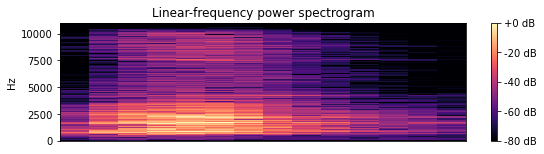

In [5]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

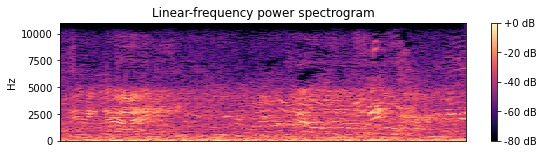

In [6]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

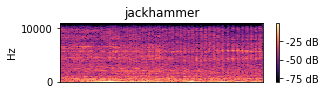

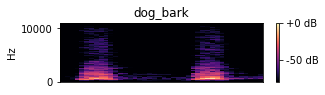

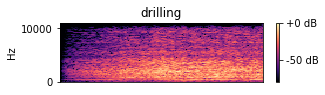

In [7]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = './audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

# Feature Extraction and Database Building

In [8]:
dat1, sampling_rate1 = librosa.load('./audio/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [9]:
spectrogram = []
classID = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = './audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        spectrogram.append(mels)
        classID.append(df["classID"][i])
    return [spectrogram, classID]

In [10]:
temp = parser(df)

In [11]:
temp

[[array([2.32836283e-05, 2.13590669e-04, 2.84403795e-04, 5.38103399e-04,
         4.95406159e-04, 1.08277681e-03, 5.19937510e-03, 3.59481527e-03,
         3.03656352e-03, 1.16137112e-03, 6.67813816e-04, 1.55336515e-03,
         1.70633418e-03, 1.82606175e-03, 3.10368440e-03, 9.18751303e-03,
         6.59603206e-03, 4.65299049e-03, 1.57605689e-02, 3.37747112e-02,
         1.05524197e-01, 3.38305801e-01, 2.80945688e-01, 3.69583160e-01,
         1.71591544e+00, 6.54988146e+00, 2.72619867e+00, 4.23764563e+00,
         5.75704861e+00, 1.17805052e+01, 3.51552963e+01, 4.23007393e+01,
         5.75337219e+01, 1.75374851e+01, 1.13725119e+01, 1.45382452e+01,
         8.21350098e+00, 5.46533108e+00, 1.78669472e+01, 3.90507698e+01,
         1.45197744e+01, 1.98418255e+01, 1.02103891e+01, 5.77536106e+00,
         1.82384861e+00, 1.47172475e+00, 1.66592813e+00, 1.40164566e+00,
         2.94289756e+00, 7.24785328e+00, 3.97097063e+00, 1.76488292e+00,
         1.71261883e+00, 3.65596056e+00, 2.84417009

In [12]:
temp = np.array(temp)
temp

array([[array([2.32836283e-05, 2.13590669e-04, 2.84403795e-04, 5.38103399e-04,
               4.95406159e-04, 1.08277681e-03, 5.19937510e-03, 3.59481527e-03,
               3.03656352e-03, 1.16137112e-03, 6.67813816e-04, 1.55336515e-03,
               1.70633418e-03, 1.82606175e-03, 3.10368440e-03, 9.18751303e-03,
               6.59603206e-03, 4.65299049e-03, 1.57605689e-02, 3.37747112e-02,
               1.05524197e-01, 3.38305801e-01, 2.80945688e-01, 3.69583160e-01,
               1.71591544e+00, 6.54988146e+00, 2.72619867e+00, 4.23764563e+00,
               5.75704861e+00, 1.17805052e+01, 3.51552963e+01, 4.23007393e+01,
               5.75337219e+01, 1.75374851e+01, 1.13725119e+01, 1.45382452e+01,
               8.21350098e+00, 5.46533108e+00, 1.78669472e+01, 3.90507698e+01,
               1.45197744e+01, 1.98418255e+01, 1.02103891e+01, 5.77536106e+00,
               1.82384861e+00, 1.47172475e+00, 1.66592813e+00, 1.40164566e+00,
               2.94289756e+00, 7.24785328e+00, 3.970

In [13]:
data = temp.transpose()
data

array([[array([2.32836283e-05, 2.13590669e-04, 2.84403795e-04, 5.38103399e-04,
               4.95406159e-04, 1.08277681e-03, 5.19937510e-03, 3.59481527e-03,
               3.03656352e-03, 1.16137112e-03, 6.67813816e-04, 1.55336515e-03,
               1.70633418e-03, 1.82606175e-03, 3.10368440e-03, 9.18751303e-03,
               6.59603206e-03, 4.65299049e-03, 1.57605689e-02, 3.37747112e-02,
               1.05524197e-01, 3.38305801e-01, 2.80945688e-01, 3.69583160e-01,
               1.71591544e+00, 6.54988146e+00, 2.72619867e+00, 4.23764563e+00,
               5.75704861e+00, 1.17805052e+01, 3.51552963e+01, 4.23007393e+01,
               5.75337219e+01, 1.75374851e+01, 1.13725119e+01, 1.45382452e+01,
               8.21350098e+00, 5.46533108e+00, 1.78669472e+01, 3.90507698e+01,
               1.45197744e+01, 1.98418255e+01, 1.02103891e+01, 5.77536106e+00,
               1.82384861e+00, 1.47172475e+00, 1.66592813e+00, 1.40164566e+00,
               2.94289756e+00, 7.24785328e+00, 3.970

In [14]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X_

(8732,) (8732,)


array([array([2.32836283e-05, 2.13590669e-04, 2.84403795e-04, 5.38103399e-04,
              4.95406159e-04, 1.08277681e-03, 5.19937510e-03, 3.59481527e-03,
              3.03656352e-03, 1.16137112e-03, 6.67813816e-04, 1.55336515e-03,
              1.70633418e-03, 1.82606175e-03, 3.10368440e-03, 9.18751303e-03,
              6.59603206e-03, 4.65299049e-03, 1.57605689e-02, 3.37747112e-02,
              1.05524197e-01, 3.38305801e-01, 2.80945688e-01, 3.69583160e-01,
              1.71591544e+00, 6.54988146e+00, 2.72619867e+00, 4.23764563e+00,
              5.75704861e+00, 1.17805052e+01, 3.51552963e+01, 4.23007393e+01,
              5.75337219e+01, 1.75374851e+01, 1.13725119e+01, 1.45382452e+01,
              8.21350098e+00, 5.46533108e+00, 1.78669472e+01, 3.90507698e+01,
              1.45197744e+01, 1.98418255e+01, 1.02103891e+01, 5.77536106e+00,
              1.82384861e+00, 1.47172475e+00, 1.66592813e+00, 1.40164566e+00,
              2.94289756e+00, 7.24785328e+00, 3.97097063e+00, 1.

In [15]:
X = np.empty([8732, 128])
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
for i in range(8732):
    X[i] = (X_[i])

In [17]:
X

array([[2.32836283e-05, 2.13590669e-04, 2.84403795e-04, ...,
        2.18676127e-04, 4.28634030e-06, 9.04005404e-08],
       [4.96083945e-02, 4.94360849e-02, 3.69195119e-02, ...,
        2.83860704e-08, 4.40721371e-09, 1.49159329e-09],
       [3.08838189e-02, 2.79413722e-02, 3.62786241e-02, ...,
        1.30676137e-08, 1.69000680e-09, 4.93818264e-10],
       ...,
       [1.60690453e-02, 6.24883585e-02, 6.20831363e-02, ...,
        4.64467757e-06, 2.96354187e-07, 1.62235665e-08],
       [2.41632219e-02, 7.74951130e-02, 6.34436682e-02, ...,
        1.53056604e-07, 1.86790388e-08, 4.82880136e-09],
       [3.62133868e-02, 5.40862568e-02, 9.46602523e-02, ...,
        9.19702813e-07, 6.86923087e-08, 2.18462559e-09]])

In [18]:
Y

array([3, 2, 2, ..., 1, 1, 1], dtype=object)

In [21]:
Y = to_categorical(Y)

In [22]:
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


# Train, Test and Validation Data Split

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify= Y, random_state = 42)

In [25]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train ,test_size=0.1, stratify=Y_train, random_state=42)

In [26]:
X_train.shape, Y_train.shape

((7072, 128), (7072, 10))

In [27]:
len(X_train),len(X_val),len(X_test)

(7072, 786, 874)

In [28]:
X_train = X_train.reshape(len(X_train), 16, 8, 1)
X_val = X_val.reshape(len(X_val), 16, 8, 1)
X_test = X_test.reshape(len(X_test), 16, 8, 1)

In [29]:
X_train.shape,X_val.shape, X_test.shape

((7072, 16, 8, 1), (786, 16, 8, 1), (874, 16, 8, 1))

In [30]:
Y_train.shape,Y_val.shape,Y_test.shape

((7072, 10), (786, 10), (874, 10))

# Save Datase

In [31]:
fileName=["X_train","X_val", "X_test","Y_train","Y_val","Y_test"]
datas=[X_train,X_val, X_test,Y_train,Y_val,Y_test]

In [32]:
import pickle
for i in range(6):
    with open(fileName[i]+'.pickle', 'wb') as output:
         pickle.dump(datas[i], output) 